In [114]:
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_auc_score, roc_curve
from xgboost import XGBClassifier, plot_tree
import numpy as np
from matplotlib.pylab import rcParams

In [115]:
with open("spreadsheet_boolean.pkl", "rb") as f:
    df = pickle.load(f)

df.head()

C:\Users\aswan\AppData\Local\Temp\ipykernel_15936\3441433889.py:2: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  df = pickle.load(f)


,date,symbol,streak_len,direction,occurrence,performance,vol,ma5_pos,ma10_pos,ma20_pos,...,ma100_pos,ma200_pos,ma5_neg,ma10_neg,ma20_neg,ma50_neg,ma100_neg,ma200_neg,next_day_actual,bin_name
0,2024-12-18,MIGI,4,-1,46,-1,1,0,0,0,...,0,0,-1,1,1,-1,-1,-1,0,4 -1 -1 -1 1 0 0 -1 -1
1,2024-12-18,PSNY,7,-1,8,1,1,0,0,0,...,0,0,1,1,-1,1,-1,-1,0,7 -1 1 1 1 0 0 1 -1
2,2024-12-18,AVNW,3,-1,536,1,1,0,0,1,...,0,0,-1,-1,0,1,1,1,0,3 -1 1 1 1 0 0 -1 1
3,2024-12-18,ANIP,3,-1,334,1,1,0,0,0,...,0,0,1,-1,-1,-1,1,1,0,3 -1 1 1 1 0 0 1 1
4,2024-12-18,GOODO,5,-1,10,1,-1,0,0,0,...,0,1,1,-1,1,-1,-1,0,0,5 -1 1 1 -1 0 1 1 0


#### Preprocessing

In [116]:
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')
df.set_index('date', inplace=True)

# Remove all the 0 values (indicating no change) from next_day_actual
df = df[df['next_day_actual'] != 0]

df['next_day_actual'] = df['next_day_actual'].replace(-1, 0)

In [117]:
df['next_day_actual'].unique()

array([0, 1])

In [118]:
df.dtypes

symbol             object
streak_len         object
direction           int64
occurrence         object
performance         int64
vol                 int64
ma5_pos             int64
ma10_pos            int64
ma20_pos            int64
ma50_pos            int64
ma100_pos           int64
ma200_pos           int64
ma5_neg             int64
ma10_neg            int64
ma20_neg            int64
ma50_neg            int64
ma100_neg           int64
ma200_neg           int64
next_day_actual     int64
bin_name           object
dtype: object

In [119]:
df['streak_len'] = df['streak_len'].astype(int)
df.drop(columns=['symbol','bin_name','occurrence'],inplace=True)
df.head()

,streak_len,direction,performance,vol,ma5_pos,ma10_pos,ma20_pos,ma50_pos,ma100_pos,ma200_pos,ma5_neg,ma10_neg,ma20_neg,ma50_neg,ma100_neg,ma200_neg,next_day_actual
date,,,,,,,,,,,,,,,,,
2024-12-17,3,1,-1,1,0,0,0,0,0,1,1,1,-1,1,-1,0,0
2024-12-17,6,-1,1,-1,0,0,0,0,0,0,1,-1,-1,-1,-1,1,0
2024-12-17,3,1,-1,1,-1,1,1,1,1,1,0,0,0,0,0,0,1
2024-12-17,3,1,-1,1,-1,0,0,0,0,0,0,1,-1,-1,1,1,1
2024-12-17,4,-1,1,-1,0,0,0,0,0,0,-1,1,1,1,-1,-1,0


### Exploratory Data Analysis (EDA)

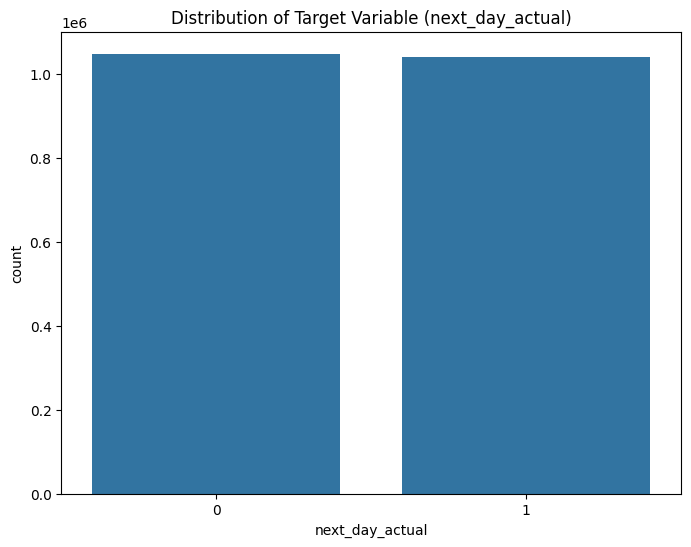

In [120]:
# Distribution of target variable
plt.figure(figsize=(8, 6))
sns.countplot(x='next_day_actual', data=df)
plt.title('Distribution of Target Variable (next_day_actual)')
plt.show()

**Correlation Heatmap:** visualizes the relationships between variables in the dataset. It uses colors to represent the strength and direction of correlations:
- **1**: Strong positive correlation (dark red).
- **-1**: Strong negative correlation (dark blue).
- **0**: No correlation (white).

This helps identify which features are strongly related and guides feature selection for modeling.

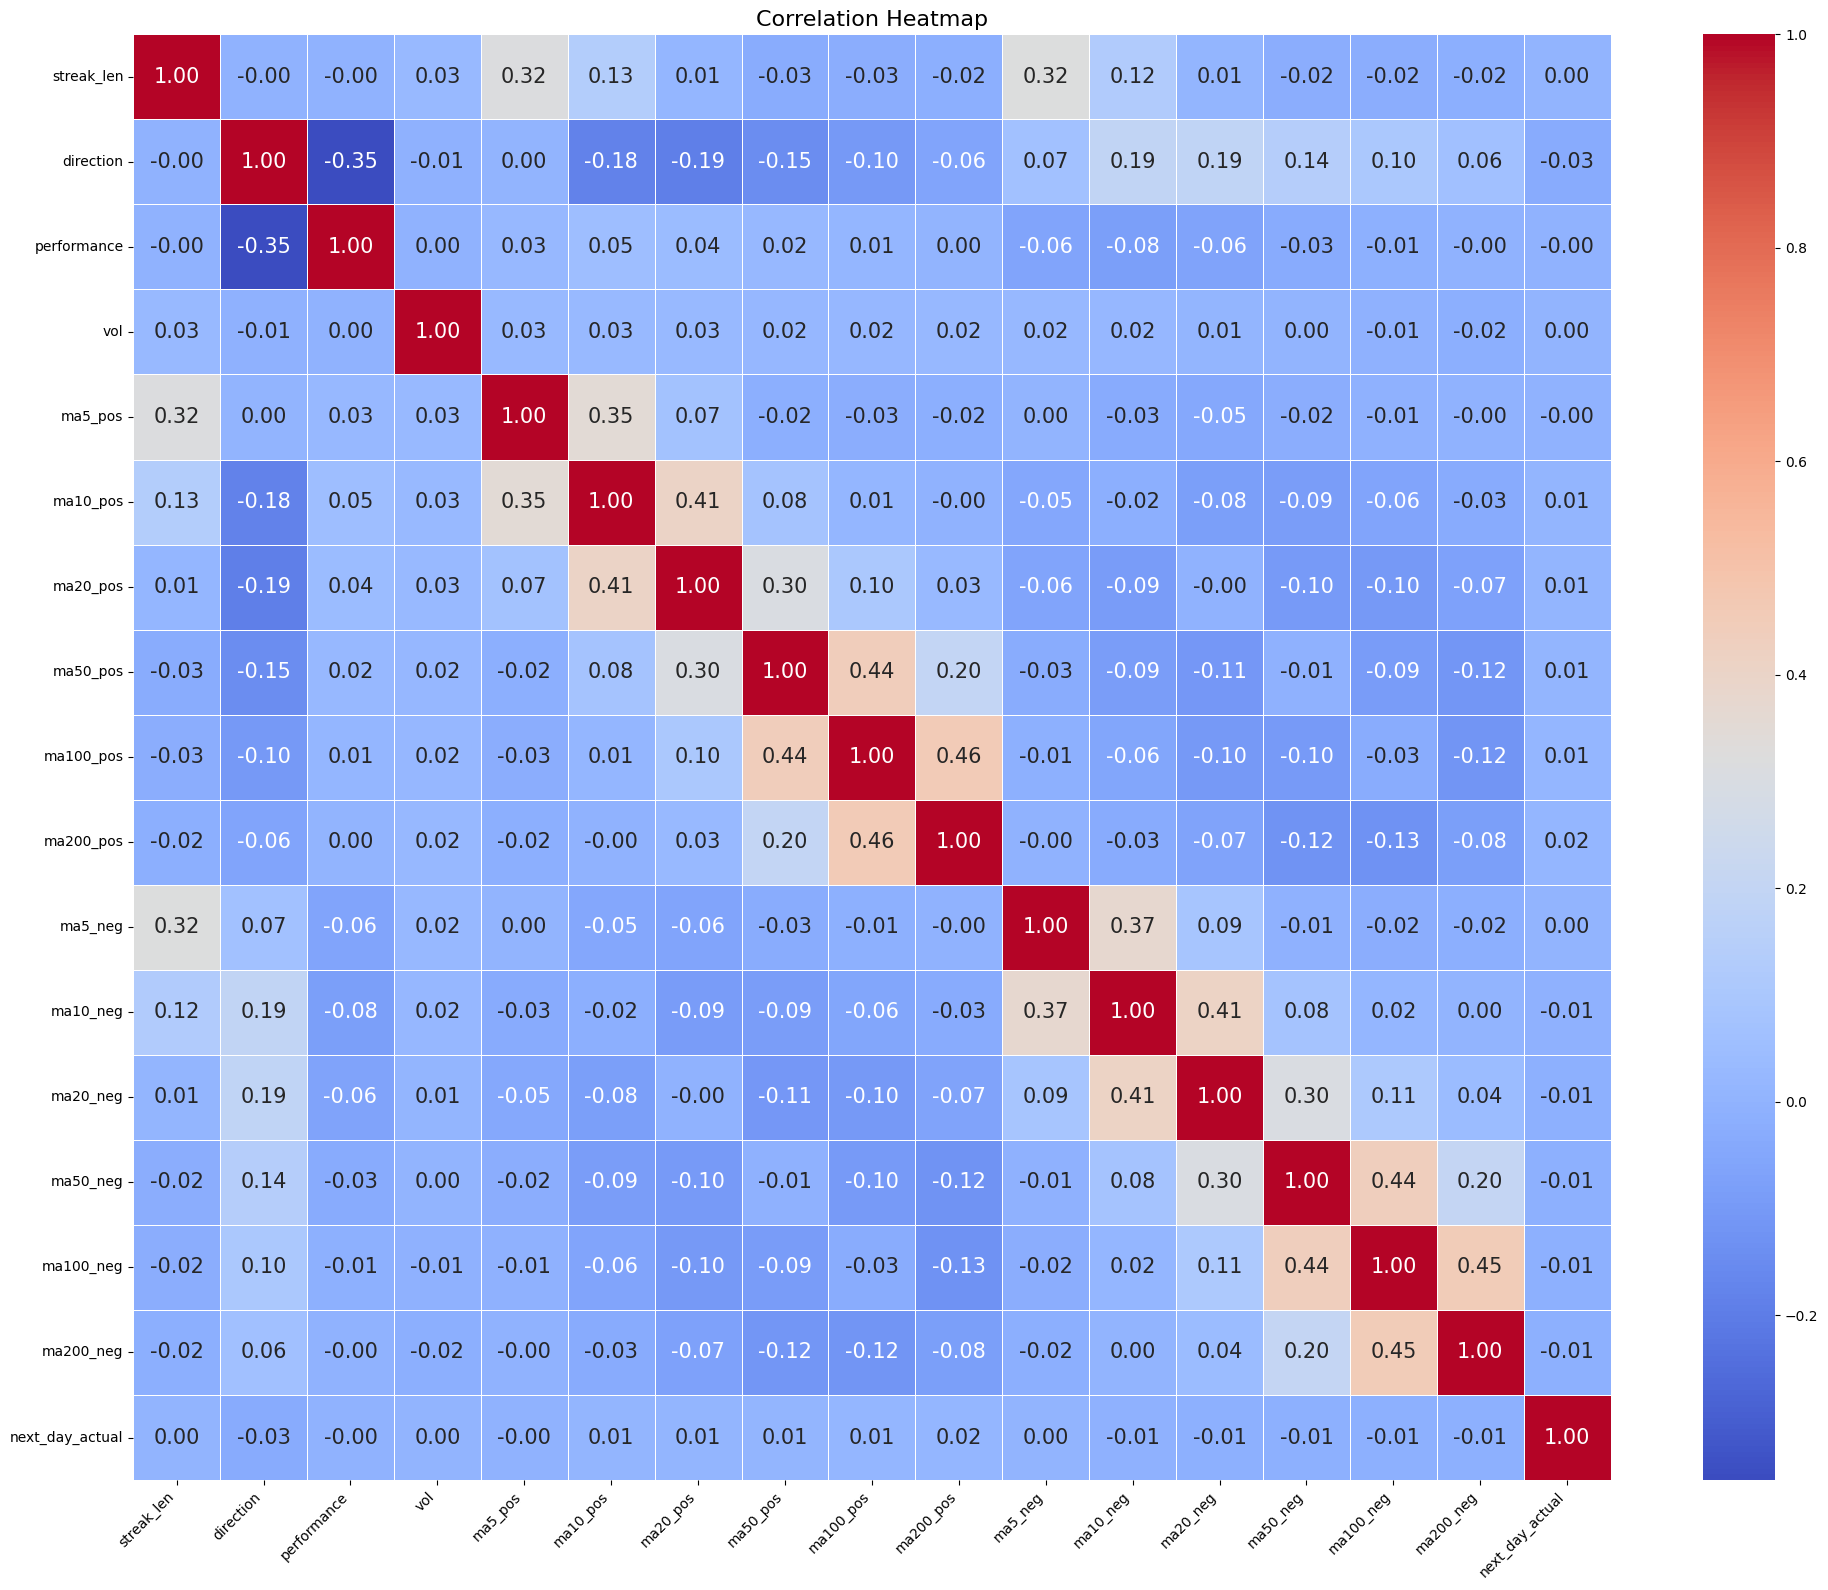

In [146]:
# Set a larger figure size
plt.figure(figsize=(20, 16))

# Plot the heatmap with smaller annotation font size
sns.heatmap(
    df.corr(), 
    annot=True, 
    cmap='coolwarm', 
    fmt='.2f',  # Format annotations to 2 decimal places
    annot_kws={'size': 15},  # Adjust annotation font size
    linewidths=0.5  # Add lines between cells for better readability
)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Add a title
plt.title('Correlation Heatmap', fontsize=16)

# Show the plot
plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

### Splitting data for training & testing

In [123]:
# Split data into features and target
x = df.iloc[:,:-1]
y = df['next_day_actual']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.2, random_state=42)

### One-Hot Encoding

In [124]:
cols = x.columns.to_list()
cols

['streak_len',
 'direction',
 'performance',
 'vol',
 'ma5_pos',
 'ma10_pos',
 'ma20_pos',
 'ma50_pos',
 'ma100_pos',
 'ma200_pos',
 'ma5_neg',
 'ma10_neg',
 'ma20_neg',
 'ma50_neg',
 'ma100_neg',
 'ma200_neg']

In [125]:
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore').fit(df[cols])
encoded_cols = list(encoder.get_feature_names_out(cols)) # it retrieves the names of the new encoded features created by the OneHotEncoder and stores them in the list encoded_cols.

In [126]:
x_train[encoded_cols] = encoder.transform(x_train[cols])
x_test[encoded_cols] = encoder.transform(x_test[cols])

In [127]:
x_train.columns

Index(['streak_len', 'direction', 'performance', 'vol', 'ma5_pos', 'ma10_pos',
       'ma20_pos', 'ma50_pos', 'ma100_pos', 'ma200_pos', 'ma5_neg', 'ma10_neg',
       'ma20_neg', 'ma50_neg', 'ma100_neg', 'ma200_neg', 'streak_len_3',
       'streak_len_4', 'streak_len_5', 'streak_len_6', 'streak_len_7',
       'streak_len_8', 'streak_len_9', 'streak_len_10', 'streak_len_11',
       'streak_len_12', 'streak_len_13', 'streak_len_14', 'streak_len_15',
       'streak_len_16', 'streak_len_17', 'streak_len_18', 'streak_len_19',
       'streak_len_20', 'streak_len_21', 'streak_len_22', 'streak_len_23',
       'streak_len_24', 'streak_len_25', 'direction_-1', 'direction_1',
       'performance_-1', 'performance_0', 'performance_1', 'vol_-1', 'vol_0',
       'vol_1', 'ma5_pos_-1', 'ma5_pos_0', 'ma5_pos_1', 'ma10_pos_-1',
       'ma10_pos_0', 'ma10_pos_1', 'ma20_pos_-1', 'ma20_pos_0', 'ma20_pos_1',
       'ma50_pos_-1', 'ma50_pos_0', 'ma50_pos_1', 'ma100_pos_-1',
       'ma100_pos_0', 'ma100_pos_1

In [128]:
# Remove original columns and keep only encoded columns
x_train = x_train[encoded_cols]
x_test = x_test[encoded_cols]

In [129]:
x_train.columns

Index(['streak_len_3', 'streak_len_4', 'streak_len_5', 'streak_len_6',
       'streak_len_7', 'streak_len_8', 'streak_len_9', 'streak_len_10',
       'streak_len_11', 'streak_len_12', 'streak_len_13', 'streak_len_14',
       'streak_len_15', 'streak_len_16', 'streak_len_17', 'streak_len_18',
       'streak_len_19', 'streak_len_20', 'streak_len_21', 'streak_len_22',
       'streak_len_23', 'streak_len_24', 'streak_len_25', 'direction_-1',
       'direction_1', 'performance_-1', 'performance_0', 'performance_1',
       'vol_-1', 'vol_0', 'vol_1', 'ma5_pos_-1', 'ma5_pos_0', 'ma5_pos_1',
       'ma10_pos_-1', 'ma10_pos_0', 'ma10_pos_1', 'ma20_pos_-1', 'ma20_pos_0',
       'ma20_pos_1', 'ma50_pos_-1', 'ma50_pos_0', 'ma50_pos_1', 'ma100_pos_-1',
       'ma100_pos_0', 'ma100_pos_1', 'ma200_pos_-1', 'ma200_pos_0',
       'ma200_pos_1', 'ma5_neg_-1', 'ma5_neg_0', 'ma5_neg_1', 'ma10_neg_-1',
       'ma10_neg_0', 'ma10_neg_1', 'ma20_neg_-1', 'ma20_neg_0', 'ma20_neg_1',
       'ma50_neg_-1', 'ma50

In [130]:
# Convert encoded columns and target column to boolean
x_train = x_train.astype(bool)
x_test = x_test.astype(bool)
y_train = y_train.astype(bool)
y_test = y_test.astype(bool)

### Hyperparameter Tuning

In [131]:
# Hyperparameter Tuning with GridSearchCV
param_grid = {
    'max_depth': [3, 4, 5],
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2]
}

grid_search = GridSearchCV(estimator=XGBClassifier(random_state=42, n_jobs=-1, eval_metric='logloss'),
                          param_grid=param_grid, scoring='accuracy', cv=3)
grid_search.fit(x_train, y_train)
print("Best Parameters:", grid_search.best_params_)

Best Parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}


### Model Training

In [132]:
# Train the model with best parameters
model = XGBClassifier(random_state=42, n_jobs=-1, eval_metric='logloss', **grid_search.best_params_)
model.fit(x_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=-1, num_parallel_tree=None, random_state=42, ...)

In [133]:
# Predictions
train_preds = model.predict(x_train)
test_preds = model.predict(x_test)

In [143]:
print(train_preds, test_preds)

[1 0 0 ... 0 1 1] [0 0 1 ... 1 1 1]


### Model Evaluation (Confusion Matrix, ROC Curve)

**Confusion Matrix:**
A confusion matrix is a table used to evaluate the performance of a classification model. It shows:
- **True Positives (TP)**: Correctly predicted positive cases.
- **True Negatives (TN)**: Correctly predicted negative cases.
- **False Positives (FP)**: Negative cases incorrectly predicted as positive.
- **False Negatives (FN)**: Positive cases incorrectly predicted as negative.

It helps visualize how well the model is performing and identify where it makes mistakes.

**Confusion Matrix (2D Array):**
In a confusion matrix `m`:

- **`m[0, 0]`**: True Negatives (TN) – Correctly predicted negatives.
- **`m[0, 1]`**: False Positives (FP) – Incorrectly predicted positives (Type I Error).
- **`m[1, 0]`**: False Negatives (FN) – Incorrectly predicted negatives (Type II Error).
- **`m[1, 1]`**: True Positives (TP) – Correctly predicted positives.

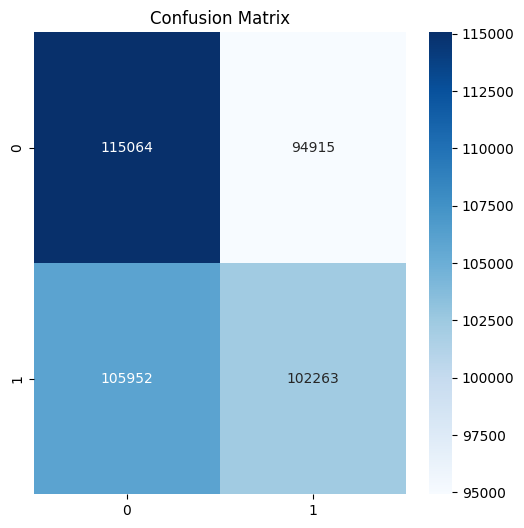

In [134]:
# Confusion Matrix
cm = confusion_matrix(y_test, test_preds)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

**ROC Curve (Receiver Operating Characteristic Curve):**
The ROC Curve visualizes the performance of a binary classification model by plotting:
- **True Positive Rate (TPR)** (y-axis): The proportion of actual positives correctly predicted.
- **False Positive Rate (FPR)** (x-axis): The proportion of actual negatives incorrectly predicted as positives.

- **AUC-ROC Score**: The area under the ROC curve, ranging from 0 to 1:
  - **1**: Perfect classifier.
  - **0.5**: Random classifier.
  - **< 0.5**: Worse than random.

The ROC Curve helps evaluate how well the model distinguishes between the two classes at different classification thresholds.

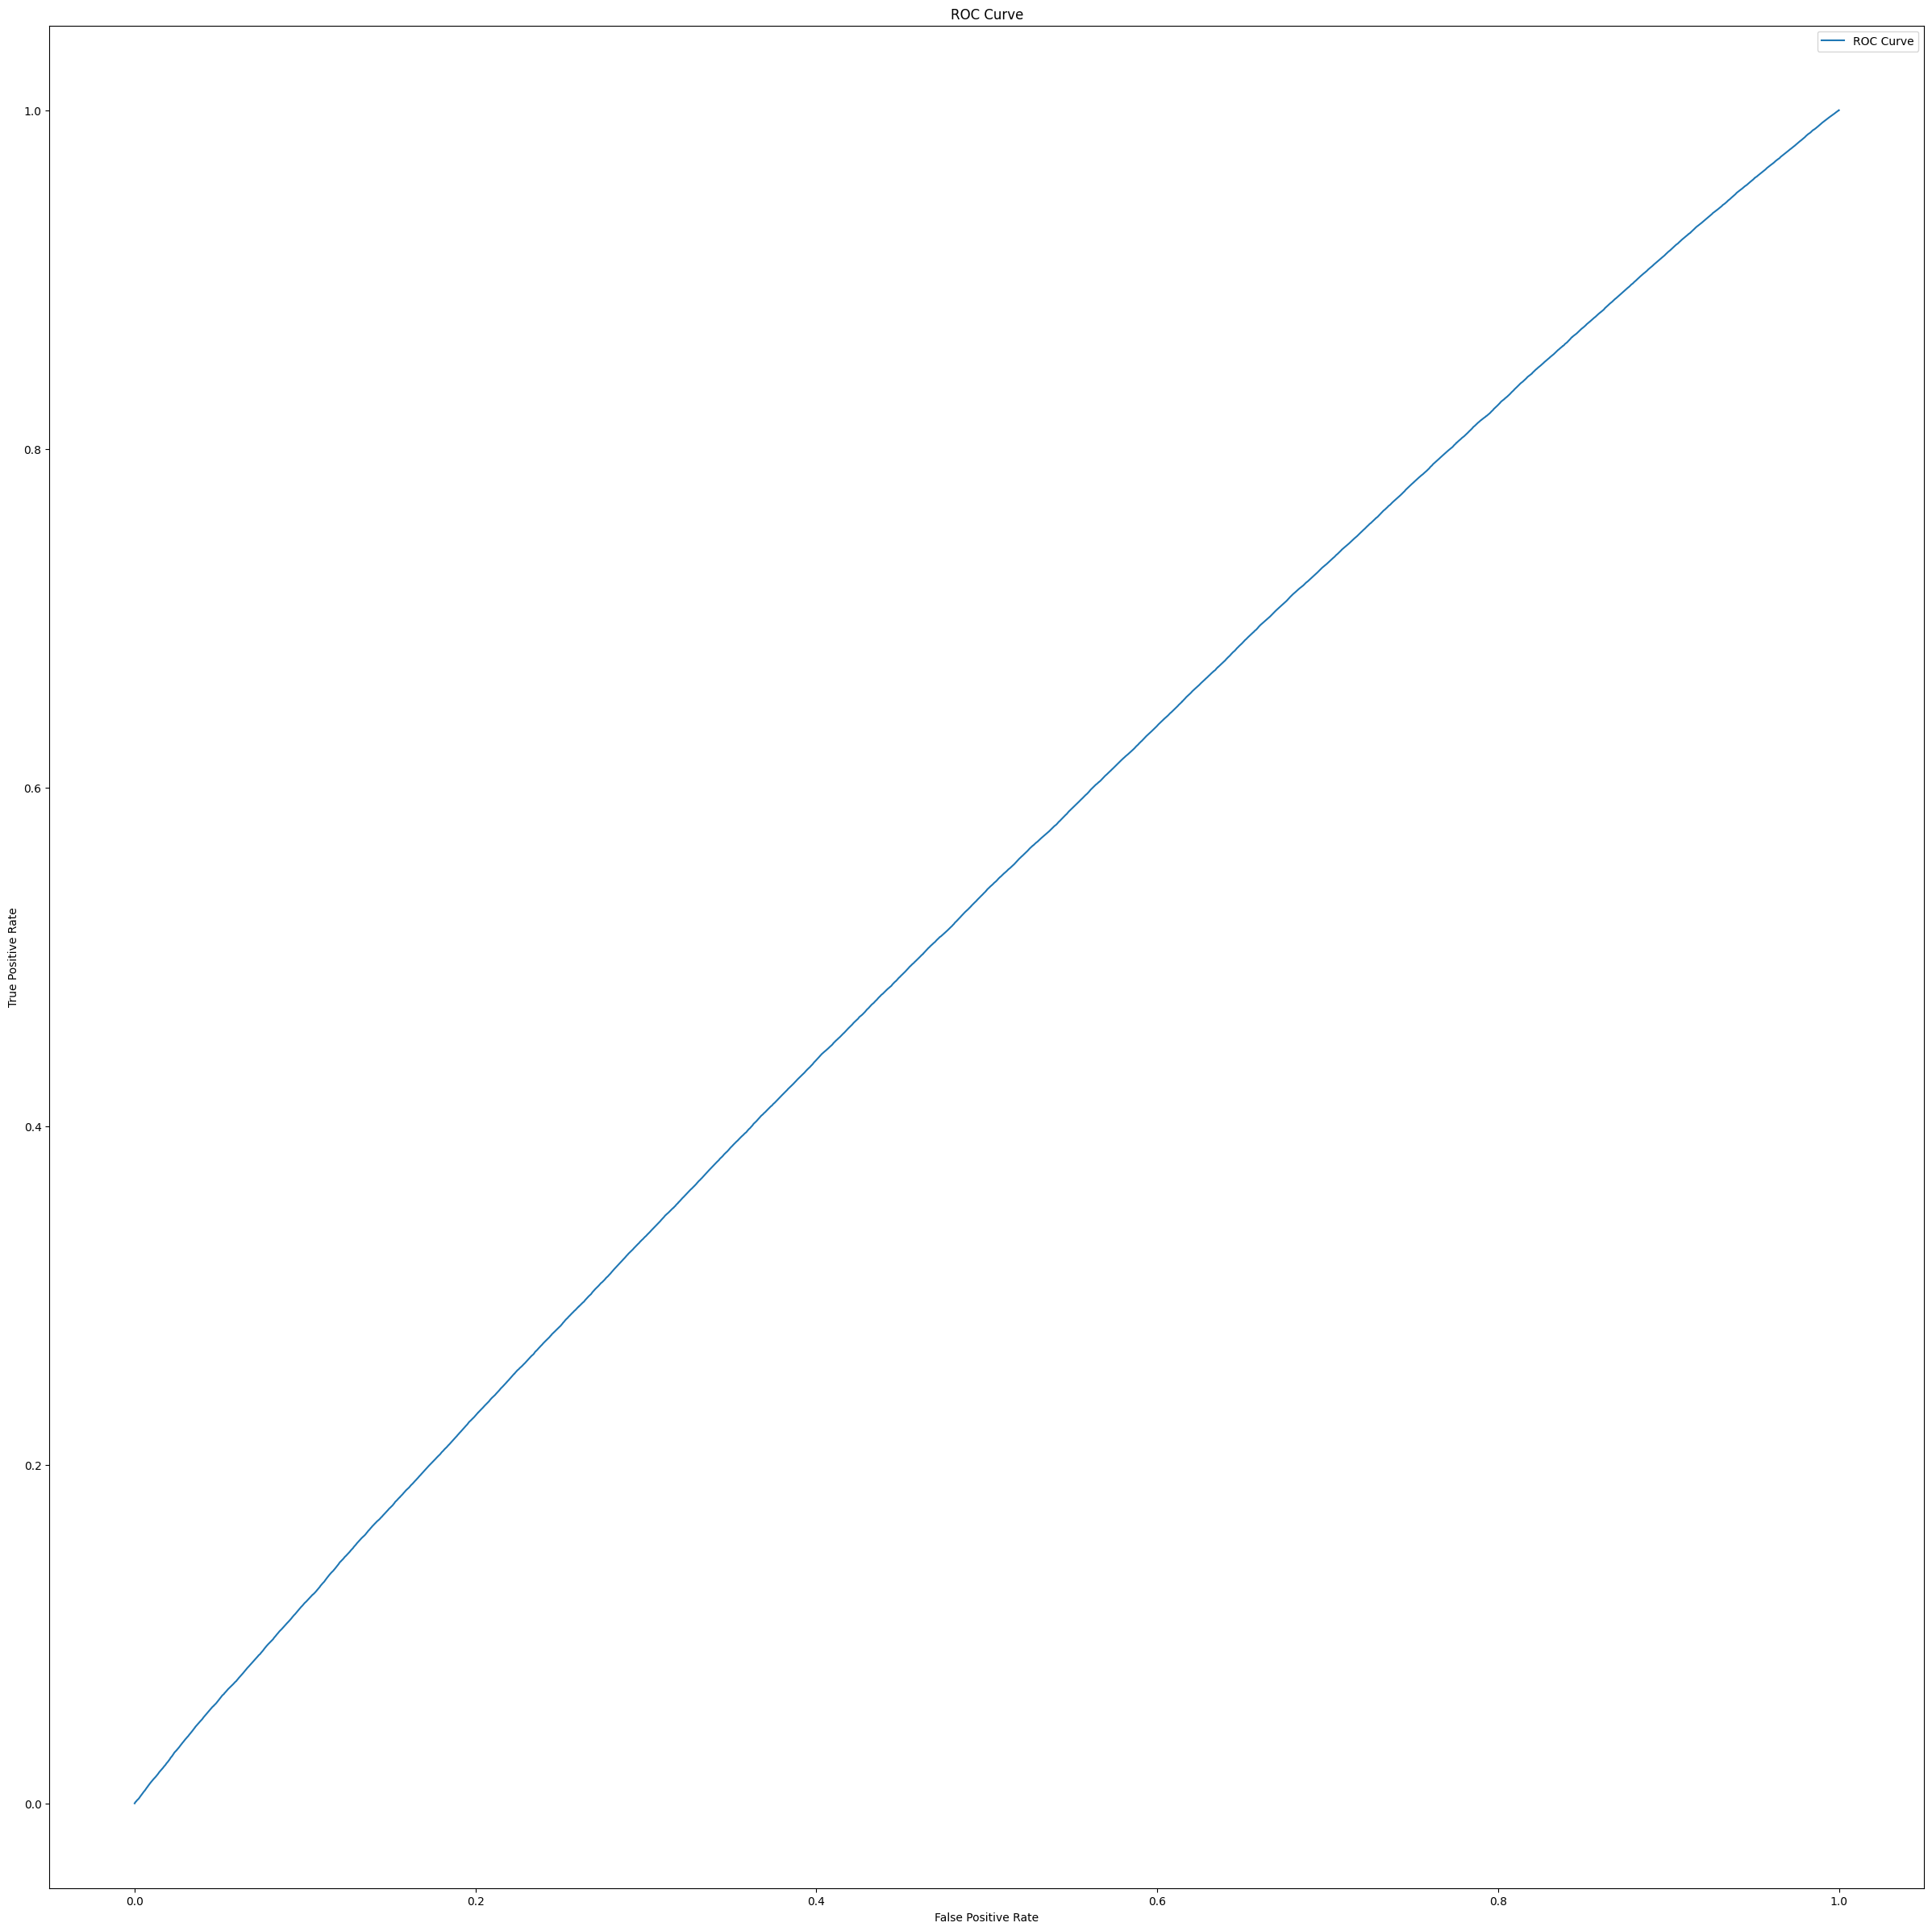

In [135]:
# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(x_test)[:, 1])
plt.plot(fpr, tpr, label='ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

In [136]:
print("AUC-ROC Score:", roc_auc_score(y_test, model.predict_proba(x_test)[:, 1]))

AUC-ROC Score: 0.5276883302662063


In [137]:
# Evaluation
print("Training Accuracy:", accuracy_score(y_train, train_preds))
print("Test Accuracy:", accuracy_score(y_test, test_preds))
print("\nClassification Report (Training):\n", classification_report(y_train, train_preds))
print("\nClassification Report (Test):\n", classification_report(y_test, test_preds))

Training Accuracy: 0.5216212580891034
Test Accuracy: 0.5196798614996867

Classification Report (Training):
               precision    recall  f1-score   support

       False       0.52      0.55      0.54    838999
        True       0.52      0.49      0.51    833776

    accuracy                           0.52   1672775
   macro avg       0.52      0.52      0.52   1672775
weighted avg       0.52      0.52      0.52   1672775


Classification Report (Test):
               precision    recall  f1-score   support

       False       0.52      0.55      0.53    209979
        True       0.52      0.49      0.50    208215

    accuracy                           0.52    418194
   macro avg       0.52      0.52      0.52    418194
weighted avg       0.52      0.52      0.52    418194



### Visualization

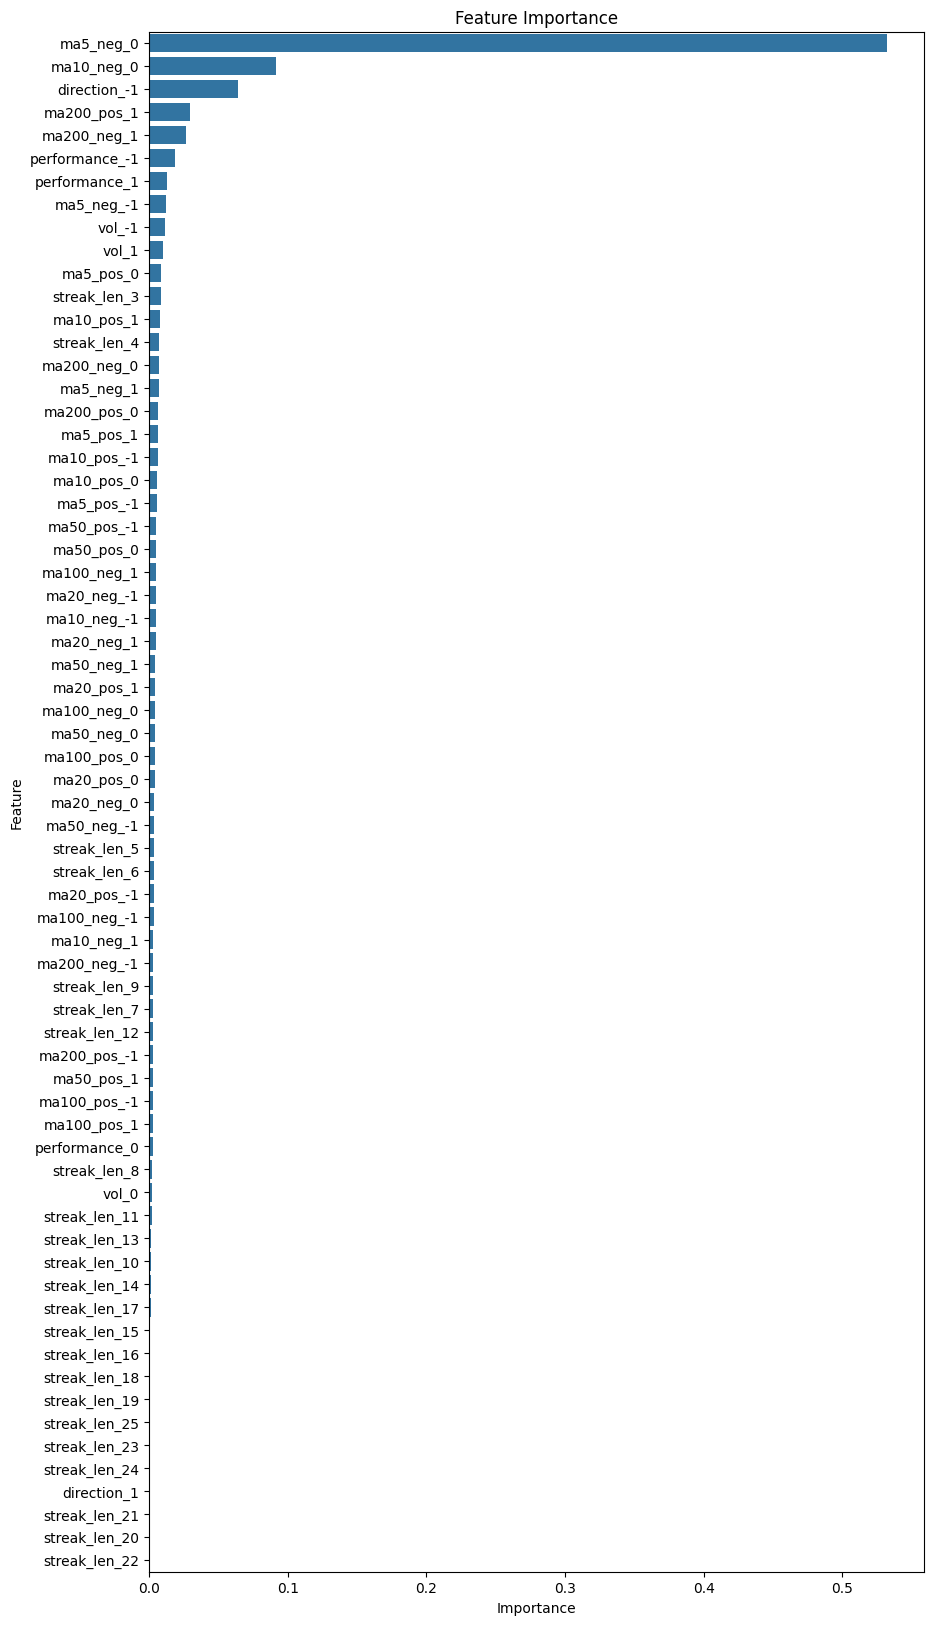

In [138]:
# Feature Importance
importance_df = pd.DataFrame({
    'Feature': x_train.columns,
    'Importance': model.feature_importances_
}).sort_values('Importance', ascending=False)

plt.figure(figsize=(10, 20))
sns.barplot(data=importance_df, x='Importance', y='Feature')
plt.title('Feature Importance')
plt.yticks(rotation=0)
plt.show()

In [139]:
# Visualization: Plot individual trees
rcParams['figure.figsize'] = 30, 30

<Axes: >

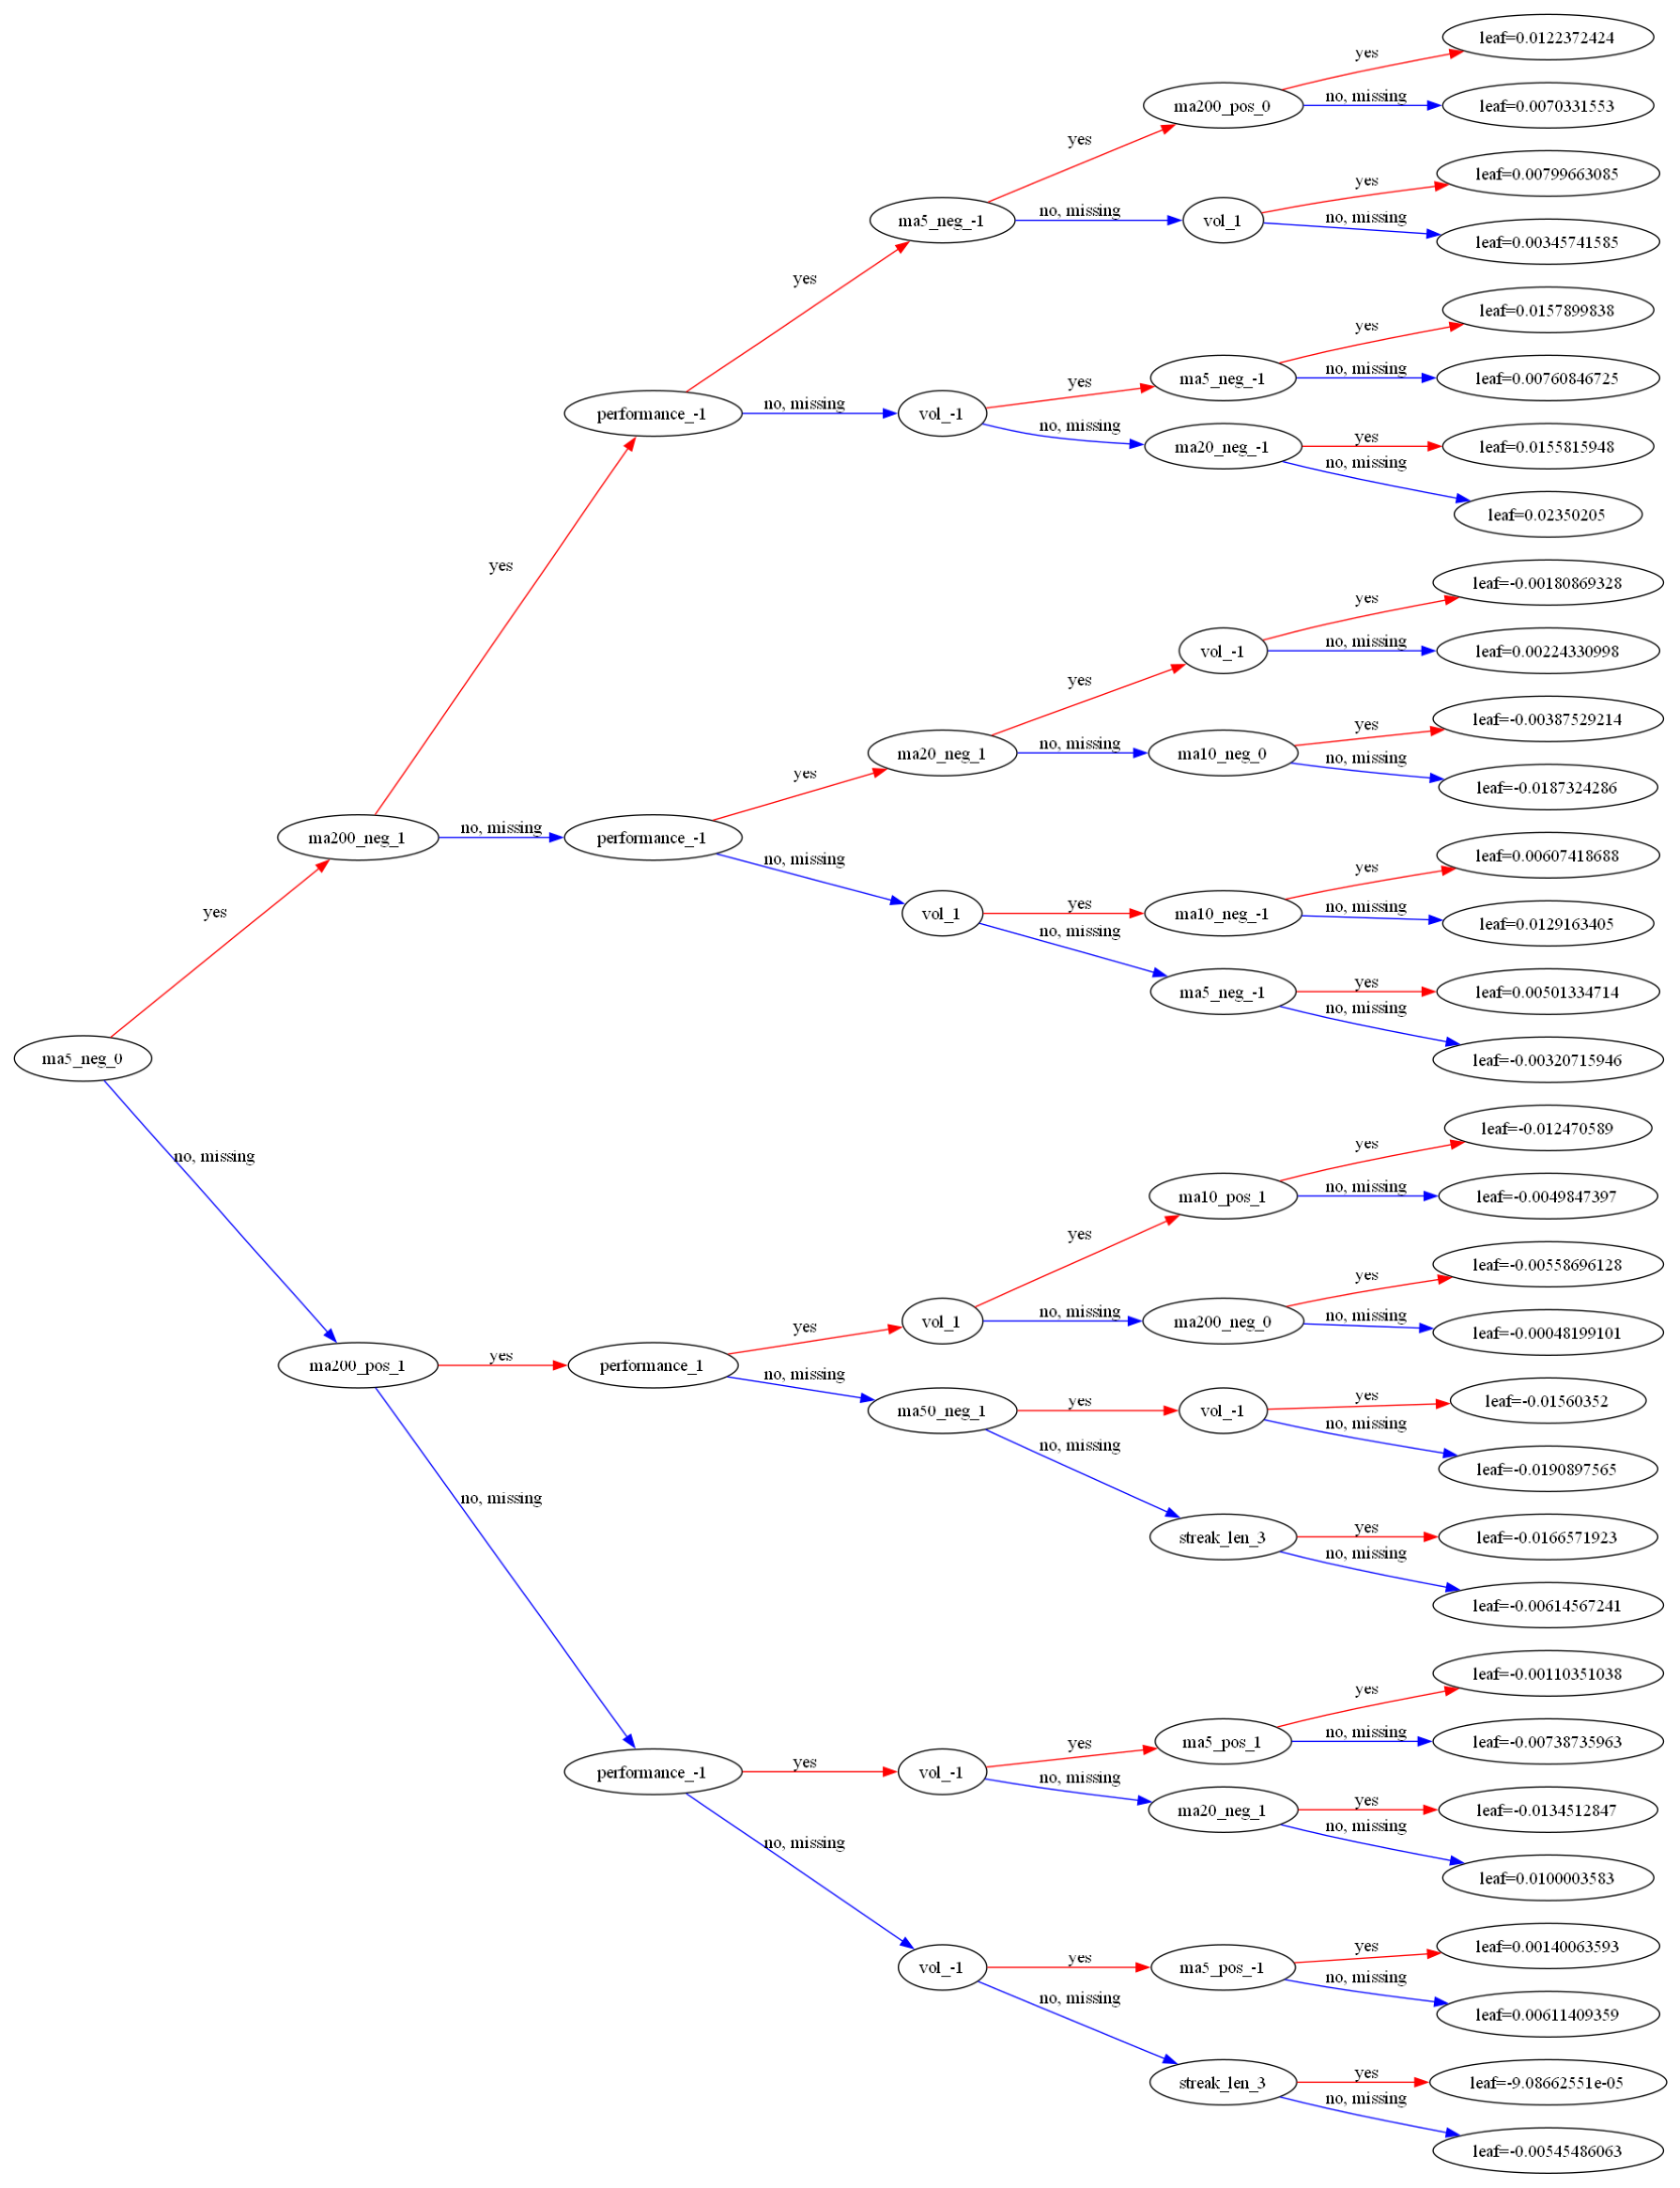

In [140]:
plot_tree(model, rankdir='LR')

<Axes: >

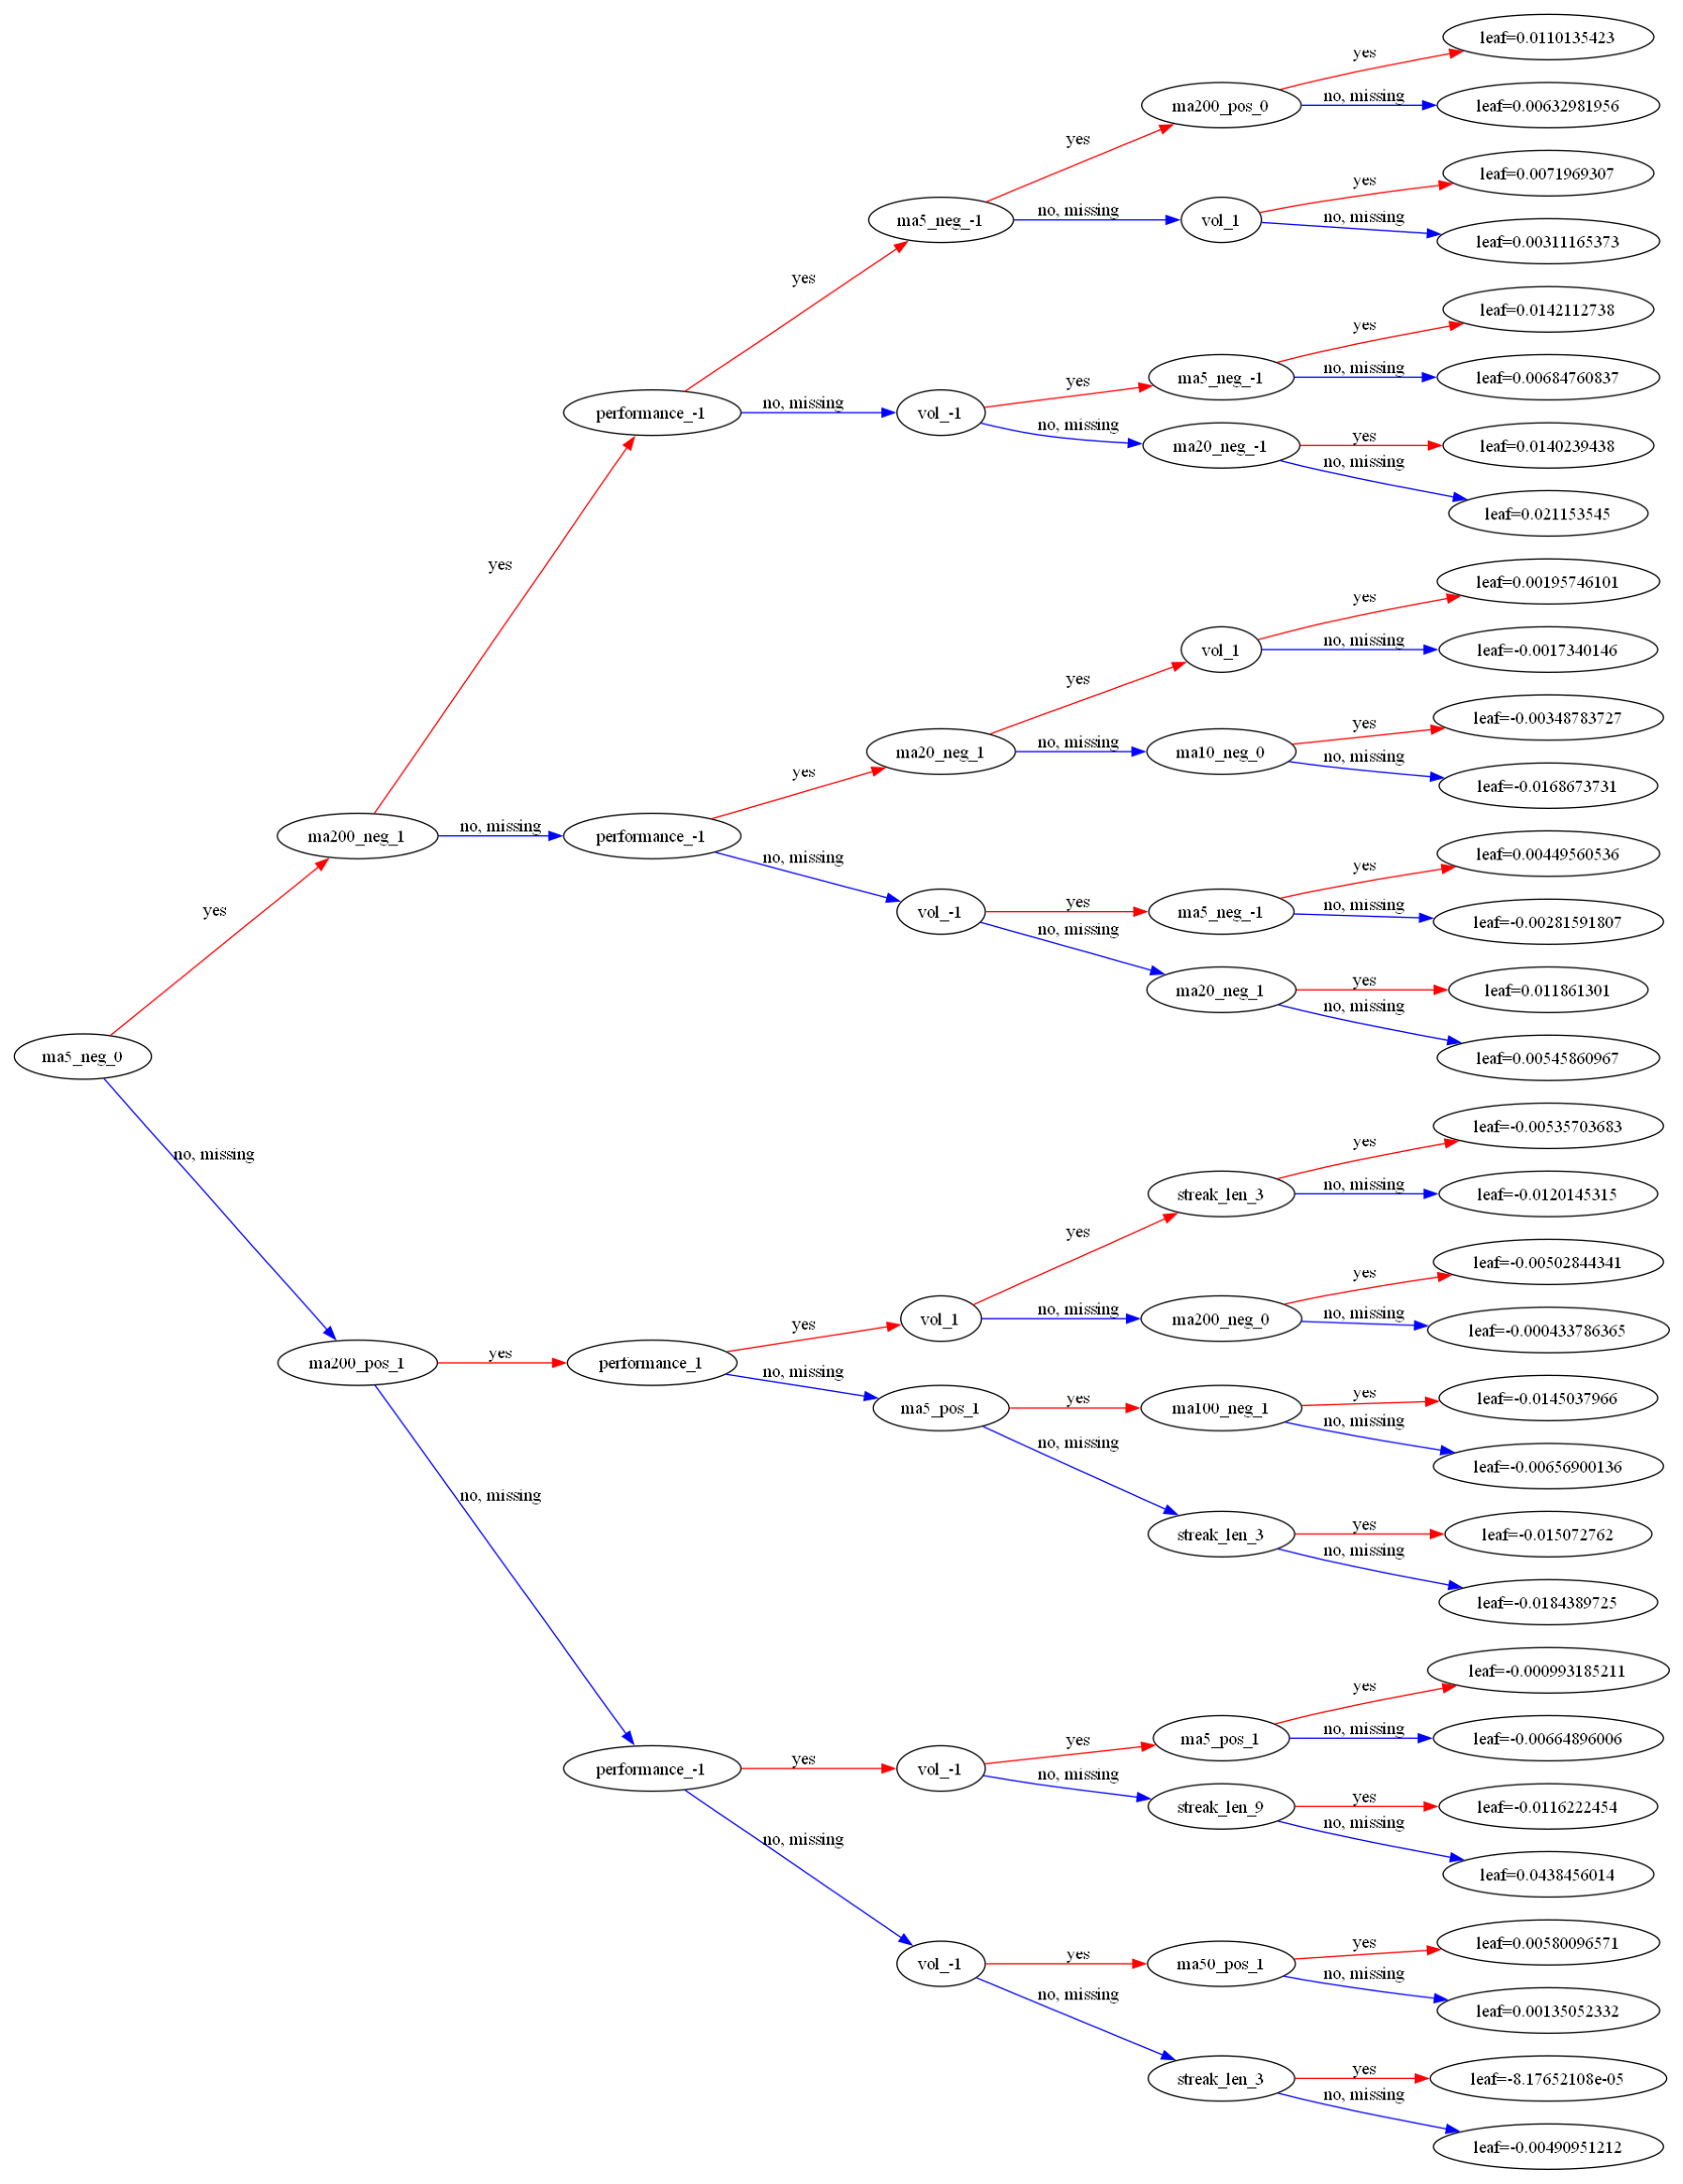

In [141]:
plot_tree(model, rankdir='LR', num_trees=1)

### K-Fold Cross Validation with Metrics

### **K-Fold Cross-Validation**
K-Fold Cross-Validation is a technique to evaluate a model's performance by splitting the dataset into `K` subsets (folds). The process involves:
1. Splitting the data into `K` equal parts.
2. Training the model on `K-1` folds and validating it on the remaining fold.
3. Repeating this process `K` times, each time using a different fold as the validation set.
4. Averaging the results to get the final performance metric.

#### **Key Metrics from K-Fold Cross-Validation**
- **Training Accuracy**: Average accuracy across all training folds.
- **Validation Accuracy**: Average accuracy across all validation folds.
- **Standard Deviation**: Measures the consistency of the model's performance across folds.

#### **Why Use K-Fold Cross-Validation?**
- Reduces overfitting by using the entire dataset for both training and validation.
- Provides a more reliable estimate of the model's performance compared to a single train-test split.

In [142]:
def train_and_evaluate(X_train, train_targets, X_val, val_targets, **params):
    model = XGBClassifier(random_state=42, n_jobs=-1, eval_metric='logloss', **params)
    model.fit(X_train, train_targets)
    train_accuracy = accuracy_score(train_targets, model.predict(X_train))
    val_accuracy = accuracy_score(val_targets, model.predict(X_val))
    return model, train_accuracy, val_accuracy

kfold = KFold(n_splits=5)
fold_accuracies = []

for train_idxs, val_idxs in kfold.split(x_train):
    X_train_fold, train_targets = x_train.iloc[train_idxs], y_train.iloc[train_idxs]
    X_val_fold, val_targets = x_train.iloc[val_idxs], y_train.iloc[val_idxs]
    model, train_accuracy, val_accuracy = train_and_evaluate(X_train_fold, train_targets, X_val_fold, val_targets, max_depth=4, n_estimators=20)
    fold_accuracies.append(val_accuracy)
    print('Train Accuracy: {}, Validation Accuracy: {}'.format(train_accuracy, val_accuracy))

print("\nAverage Validation Accuracy:", np.mean(fold_accuracies))
print("Standard Deviation:", np.std(fold_accuracies))

# Average predictions from K-Fold models
def predict_avg(models, inputs):
    return np.mean([model.predict(inputs) for model in models], axis=0)

avg_preds = predict_avg(models, x_train)
print("\nAverage Predictions from K-Fold Models:\n", avg_preds)

Train Accuracy: 0.520581070377068, Validation Accuracy: 0.5182735275216332
Train Accuracy: 0.5201745602367324, Validation Accuracy: 0.5196156087937708
Train Accuracy: 0.5203561447295662, Validation Accuracy: 0.5187756871067537
Train Accuracy: 0.5201342081272138, Validation Accuracy: 0.5199025571281254
Train Accuracy: 0.5204017276680964, Validation Accuracy: 0.5196724006516118

Average Validation Accuracy: 0.519247956240379
Standard Deviation: 0.000619091793350919

Average Predictions from K-Fold Models:
 [1. 0. 0. ... 0. 1. 1.]
